In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
from copy import copy
from scipy.special import k0
from scipy.stats import entropy as entropy_
import matplotlib.gridspec as gridspec

## Infotaxis

Modified from: https://github.com/rkp8000/infotaxis/blob/master/infotaxis.py

In [3]:
###Entropy calculation
def entropy(log_p_src):
    """
    Wrapper around scipy.stats entropy function that takes in a 2D
    log probability distribution.
    :param log_p_src: 2D array of log probabilities
    """
    # convert to non-log probability distribution
    p_src = np.exp(log_p_src)
    # make sure it normalizes to 1
    p_src /= p_src.sum()
    # calculate entropy
    return entropy_(p_src.flatten())

In [4]:
###Bessel function
def log_k0(x):
    """
    Logarithm of modified bessel function of the second kind of order 0.
    Infinite values may still be returned if argument is too close to
    zero.
    """
    y = k0(x)
    # if array
    try:
        logy = np.zeros(x.shape, dtype=float)
        # attempt to calculate bessel function for all elements in x
        logy[y!=0] = np.log(y[y!=0])
        # for zero-valued elements use approximation
        logy[y==0] = -x[y==0] - np.log(x[y==0]) + np.log(np.sqrt(np.pi/2))
        return logy
    except:
        if y == 0:
            return -x - np.log(x) + np.log(np.sqrt(np.pi/2))
        else:
            return np.log(y)

In [20]:
###Source prior
def build_log_src_prior(prior_type, xs, ys):
    """
    Construct a log-probability distribution from a prior type specifier.
    Units are probability per area.
    """
    shape = (len(xs), len(ys))
    dx = np.mean(np.diff(xs))
    dy = np.mean(np.diff(ys))
    if prior_type == 'uniform':
        log_p_unnormalized = np.ones(shape)
        norm_factor = np.sum(np.exp(log_p_unnormalized) * dx * dy)
        log_norm_factor = np.log(norm_factor)
        log_src_prior = log_p_unnormalized - log_norm_factor
    else:
        raise NotImplementedError
    return log_src_prior

In [25]:
###Grid world action
def get_moves(pos, xs, ys, step):
    """
    Get the 5 possible moves from a position given a constant speed.
    (left, right, forward, back, stay still)
    :param pos:
    :param xs:
    :param ys:
    :param step:
    :return:
    """
    moves = []
    for dx, dy in [(-step, 0), (step, 0), (0, -step), (0, step), (0, 0)]:
        x = pos[0] + dx
        y = pos[1] + dy
        moves.append((x, y))
    return moves

In [26]:
###P(y)
def get_p_src_found(pos, xs, ys, log_p_src, radius):
    """
    Return the probability that a position is within "radius"
    of the source, given the source probability distribution.
    :param pos: position to calc prob that you are close to source
    :param xs: x-coords over which source prob distribution is defined
    :param ys: y-coords over which source prob distribution is defined
    :param log_p_src: log probability distribution over source position
    :param radius: distance you must be to source to detect it
    :return: probability
    """
    # get mask containing only points within radius of pos
    xs_, ys_ = np.meshgrid(xs, ys, indexing='ij')
    dxs = pos[0] - xs_
    dys = pos[1] - ys_

    mask = (dxs**2 + dys**2 < radius**2)

    # sum probabilities contained in mask
    p_src = np.exp(log_p_src)
    p_src /= p_src.sum()
    p_src_found = p_src[mask].sum()

    return p_src_found

In [27]:
###Environment
def get_length_constant(w, d, tau):
    """
    Return the turbulence length constant: sqrt( (d*tau) / (1 + (tau * w**2)/(4d) ) )
    :param d: diffusivity coefficient (m^2/s)
    :param w: wind speed (m/s)
    :param tau: particle lifetime (s)
    :return: length constant (m)
    """
    num = d * tau
    denom = 1 + (tau * w**2) / (4 * d)
    return np.sqrt(num / denom)

In [28]:
###R(y-x)
def get_hit_rate(xs_src, ys_src, pos, w, d, r, a, tau, resolution=0.000001):
    """
    Calculate hit rate at specified position for grid of possible source locations.
    This is given by Eq. 7 in the infotaxis paper supplementary materials:
        http://www.nature.com/nature/journal/v445/n7126/extref/nature05464-s1.pdf
    :param xs_src: 1-D array of x-positions of source (m)
    :param ys_src: 1-D array of y-positions of source (m)
    :param pos: position where hit rate is calculated (m)
    :param w: wind speed (m/s)
    :param d: diffusivity coefficient (m^2/s)
    :param r: source emission rate (Hz)
    :param a: searcher size (m)
    :param tau: particle lifetime (s)
    :return: grid of hit rates, with one value per source location
    """
    # convert xs_src & ys_src
    xs_src_, ys_src_ = np.meshgrid(xs_src, ys_src, indexing='ij')
    dx = pos[0] - xs_src_
    dy = pos[1] - ys_src_
    # round dx's and dy's less than resolution down to zero
    dx[np.abs(dx) < resolution] = 0
    dy[np.abs(dy) < resolution] = 0
    # calc lambda
    lam = get_length_constant(w=w, d=d, tau=tau)
    # calc scale factor
    scale_factor = r / np.log(lam/a)
    # calc exponential term
    exp_term = np.exp((w/(2*d))*dx)
    # calc bessel term
    abs_dist = (dx**2 + dy**2) ** 0.5
    bessel_term = np.exp(log_k0(abs_dist / lam))
    # calc final hit rate
    hit_rate = scale_factor * exp_term * bessel_term
    return hit_rate

In [29]:
###
def get_p_sample(pos, xs, ys, dt, h, w, d, r, a, tau, log_p_src):
    """
    Get the probability of sampling h at position pos.
    :param pos: position
    :param xs: x-coords over which source prob distribution is defined
    :param ys: y-coords over which source prob distribution is defined
    :param dt: sampling interval
    :param h: sample value
    :param w: wind speed (m/s)
    :param d: diffusivity coefficient (m^2/s)
    :param r: source emission rate (particles per s)
    :param log_p_src: log probability distribution over source position
    :return: probability
    """
    # poisson probability of no hit given mean hit rate
    hit_rate = get_hit_rate(xs, ys, pos, w, d, r, a, tau)
    p_no_hits = np.exp(-dt * hit_rate)
    if h == 0:
        p_samples = p_no_hits
    elif h == 1:
        p_samples = 1 - p_no_hits
    else:
        raise Exception('h must be either 0 (no hit) or 1 (hit)')
    # get source distribution
    p_src = np.exp(log_p_src)
    p_src /= p_src.sum()
    # make sure p_src being 0 wins over p_sample being nan/inf
    p_samples[p_src == 0] = 0
    # average over all source positions
    p_sample = np.sum(p_samples * p_src)
    return p_sample

In [30]:
###New P(y)
def update_log_p_src(pos, xs, ys, dt, h, w, d, r, a, tau, src_radius, log_p_src):
    """
    Update the log posterior over the src given sample h at position pos.
    :param pos: position
    :param xs: x-coords over which src prob is defined
    :param ys: y-coords over which src prob is defined
    :param h: sample value (0 for no hit, 1 for hit)
    :param w: wind speed (m/s)
    :param d: diffusivity coefficient (m^2/s)
    :param r: src emission rate (Hz)
    :param a: searcher size (m)
    :param tau: particle lifetime (s)
    :param src_radius: how close agent must be to src to detect it
    :param log_p_src: previous estimate of log src posterior
    :return: new (unnormalized) log src posterior
    """
    # first get mean number of hits at pos given different src positions
    mean_hits = dt * get_hit_rate(
        xs_src=xs, ys_src=ys, pos=pos, w=w, d=d, r=r, a=a, tau=tau)
    # calculate log-likelihood (prob of h at pos given src position [Poisson])
    if h == 0:
        log_like = -mean_hits
    else:
        log_like = np.log(1 - np.exp(-mean_hits))
    # compute the new log src posterior
    log_p_src = log_like + log_p_src
    # set log prob to -inf everywhere within src_radius of pos
    xs_, ys_ = np.meshgrid(xs, ys, indexing='ij')
    mask = ((pos[0] - xs_)**2 + (pos[1] - ys_)**2 < src_radius**2)
    log_p_src[mask] = -np.inf
    # if we've exhausted the search space start over
    if np.all(np.isinf(log_p_src)):
        log_p_src = np.ones(log_p_src.shape)
    return log_p_src

In [31]:
def simulate(
        plume, grid, start_pos, speed, dt, max_dur,
        th, src_radius, w, d, r, a=0.003, tau=100, return_log_p_srcs=False):
    """
    Run the infotaxis simulation.
    :param plume: plume object
    :param grid: number of (x, y) points in grid spanning plume environment
        to run infotaxis agent along
    :param start_pos: insect starting position (m)
    :param speed: insect movement speed (m/s)
    :param dt: simulation time step (s)
    :param max_dur: maximum simulation duration (s)
    :param th: threshold for hit detection
    :param src_radius: how close agent must be to source to detect it (m)
    :param w: wind speed (m/s)
    :param d: diffusivity coefficient (m^2/s)
    :param r: source emission rate (Hz)
    :param a: searcher size (m)
    :param tau: particle lifetime (s)
    :param return_log_p_srcs: whether to return a list of the source posteriors
        calculated along the trajectory
    :return: trajectory, hit array, src_found flag, [list of source posteriors]
    """
    if get_length_constant(w=w, d=d, tau=tau) <= a:
        raise Exception('lambda must be greater than a')

    # compute some useful auxiliary variables
    xbs_ = plume.x_bounds
    ybs_ = plume.y_bounds
    xs = np.linspace(xbs_[0], xbs_[1], grid[0])
    ys = np.linspace(ybs_[0], ybs_[1], grid[1])

    sample_domain = [0, 1]

    # initialize (log of) source distribution and position
    log_p_src = build_log_src_prior('uniform', xs=xs, ys=ys)

    # loop over time steps

    pos = start_pos
    traj = [copy(pos)]  # position sequence
    hs = []  # hit sequence
    ss = []  # entropy sequence
    log_p_srcs = []  # log src posterior sequence

    for t_ctr, t in enumerate(np.arange(0, max_dur, dt)):

        # check if source has been found
        if np.linalg.norm(np.array(pos) - plume.src_pos) < src_radius:
            src_found = True
            break

        # sample hit or miss from plume
        c = plume.sample(pos, t)
        h = int(c >= th)
        hs.append(h)

        # update source posterior
        log_p_src = update_log_p_src(
            pos=pos, xs=xs, ys=ys, dt=dt, h=h,
            w=w, d=d, r=r, a=a, tau=tau, src_radius=src_radius, log_p_src=log_p_src)
        s = entropy(log_p_src)

        ss.append(s)
        if return_log_p_srcs: log_p_srcs.append(log_p_src)

        # pick next move so as to maximally decrease expected entropy
        moves = get_moves(pos, xs, ys, step=speed*dt)
        delta_s_expecteds = []

        # get entropy decrease given src found
        delta_s_src_found = -s

        # estimate expected decrease in p_source entropy for each possible move
        # (each "move" is a new (x, y) position in SI units)
        for move in moves:

            # set entropy increase to inf if move is out of bounds
            if not round(xbs_[0], 6) <= round(move[0], 6) <= round(xbs_[1], 6):
                delta_s_expecteds.append(np.inf)
                continue
            elif not round(ybs_[0], 6) <= round(move[1], 6) <= round(ybs_[1], 6):
                delta_s_expecteds.append(np.inf)
                continue

            # get probability of finding source
            p_src_found = get_p_src_found(
                pos=move, xs=xs, ys=ys, log_p_src=log_p_src, radius=src_radius)
            p_src_not_found = 1 - p_src_found

            # loop over probability and expected entropy decrease for each sample
            p_samples = np.nan * np.zeros(len(sample_domain))
            delta_s_given_samples = np.nan * np.zeros(len(sample_domain))

            for ctr, h in enumerate(sample_domain):

                # probability of sampling h at pos
                p_sample = get_p_sample(
                    pos=move, xs=xs, ys=ys, dt=dt, h=h,
                    w=w, d=d, r=r, a=a, tau=tau, log_p_src=log_p_src)

                # posterior distribution from sampling h at pos
                log_p_src_ = update_log_p_src(
                    pos=move, xs=xs, ys=ys, dt=dt, src_radius=src_radius,
                    h=h, w=w, d=d, r=r, a=a, tau=tau, log_p_src=log_p_src)

                # decrease in entropy for this move/sample
                s_ = entropy(log_p_src_)
                delta_s_given_sample = s_ - s

                p_samples[ctr] = p_sample
                delta_s_given_samples[ctr] = delta_s_given_sample

            # get expected entropy decrease given source not found
            delta_s_src_not_found = p_samples.dot(delta_s_given_samples)

            # compute total expected entropy decrease
            delta_s_expected = (p_src_found * delta_s_src_found) + \
                (p_src_not_found * delta_s_src_not_found)

            delta_s_expecteds.append(delta_s_expected)

       # choose move that decreases p_source entropy the most
        pos = moves[np.argmin(delta_s_expecteds)]
        traj.append(copy(pos))

    else:
        src_found = False

    # convert results to arrays
    traj = np.array(traj)
    hs = np.array(hs)

    # remove last position so that traj and hs are same length
    traj = traj[:-1]

    # return pos sequence, hit sequence, src_found flag, and optionally log_p_src
    if not return_log_p_srcs:
        return traj, hs, src_found
    else:
        return traj, hs, src_found, log_p_srcs

In [33]:
class IdealInfotaxisPlume(object):

        def __init__(self, src_pos, w, d, r, a, tau, dt):
            self.src_pos = np.array(src_pos)
            self.w = w
            self.d = d
            self.r = r
            self.tau = tau

            self.a = a
            self.dt = dt

            self.x_bounds = (0, 2)
            self.y_bounds = (0, 1)

        def sample(self, pos, t):
            xs_src = np.array([self.src_pos[0]])
            ys_src = np.array([self.src_pos[1]])

            hit_rate = get_hit_rate(
                xs_src=xs_src, ys_src=ys_src, pos=pos,
                w=self.w, d=self.d, r=self.r, a=self.a, tau=self.tau)[0, 0]

            mean_hits = hit_rate * self.dt

            sample = int(np.random.poisson(mean_hits) > 0)

            return sample

        def get_profile(self, grid):

            xs = np.linspace(*self.x_bounds, num=grid[0])
            ys = np.linspace(*self.y_bounds, num=grid[1])

            xs_src = np.array([self.src_pos[0]])
            ys_src = np.array([self.src_pos[1]])

            conc = np.nan * np.zeros((len(xs), len(ys)))
            for x_ctr, x in enumerate(xs):
                for y_ctr, y in enumerate(ys):
                    hit_rate = get_hit_rate(
                        xs_src=xs_src, ys_src=ys_src, pos=(x, y),
                        w=self.w, d=self.d, r=self.r, a=self.a, tau=self.tau)[0, 0]

                    conc[x_ctr, y_ctr] = hit_rate

            dx = np.mean(np.diff(xs))
            dy = np.mean(np.diff(ys))

            x_lim = [xs[0] - dx/2, xs[-1] + dx/2]
            y_lim = [ys[0] - dy/2, ys[-1] + dy/2]

            extent = x_lim + y_lim

            return conc, extent

In [36]:
seed=0
grid=(101, 51)
src_pos=(.1, .5)
start_pos=(1.9, .9)
dt=.1
speed=.2
max_dur=40
th=.5
src_radius=.02
w=.5
d=.05
r=5
a=.003
tau=100

#plume environment
plume = IdealInfotaxisPlume(
        src_pos=src_pos, w=w, d=d, r=r, a=a, tau=tau, dt=dt)

#run infotaxis simulation
traj, hs, src_found, log_p_srcs = simulate(
    plume=plume, grid=grid, start_pos=start_pos, speed=speed, dt=dt,
    max_dur=max_dur, th=th, src_radius=src_radius, w=w, d=d, r=r, a=a, tau=tau,
    return_log_p_srcs=True)

Text(0.5, 1.0, 'full trajectory with plume profile')

/Users/Macintosh/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


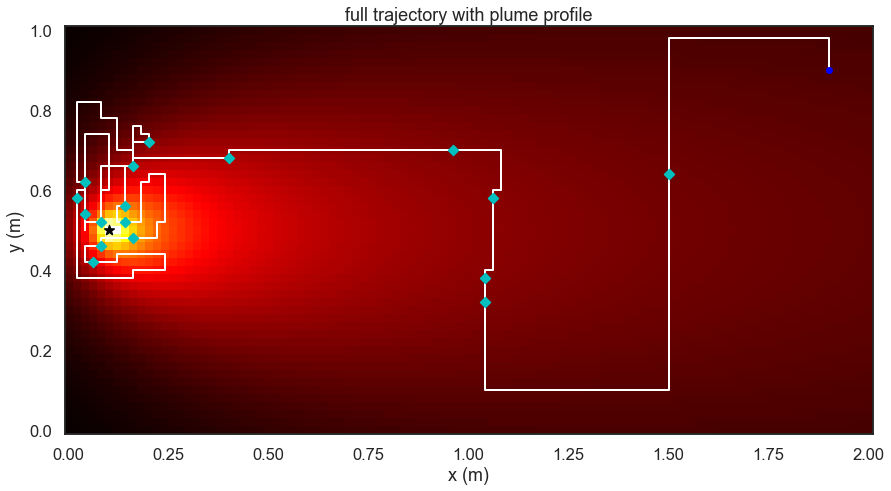

In [52]:
# plot trajectory
gs = gridspec.GridSpec(5, 2)
fig, axs = plt.figure(figsize=(15, 16), tight_layout=True), []

# plot full trajectory overlaid on plume profile
conc, extent = plume.get_profile(grid)
ax_main = fig.add_subplot(gs[:2, :])
ax_main.imshow(conc.T, origin='lower', extent=extent, cmap='hot', zorder=0)

# plot trajectory and hits
ax_main.plot(traj[:, 0], traj[:, 1], lw=2, color='w', zorder=1)
ax_main.scatter(
    traj[hs > 0, 0], traj[hs > 0, 1], marker='D', s=50, c='c', zorder=2)
# mark starting position
ax_main.scatter(*start_pos, s=30, c='b', zorder=2)
# mark source location
ax_main.scatter(*plume.src_pos, marker='*', s=100, c='k', zorder=2)

# set figure axis limits
ax_main.set_xlim(extent[:2])
ax_main.set_ylim(extent[2:])

# make figure labels
ax_main.set_xlabel('x (m)')
ax_main.set_ylabel('y (m)')
ax_main.set_title('full trajectory with plume profile')